In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [0]:

import os
import PIL
import imageio
import pandas as pd
import numpy as np
import random
import math
import keras
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential 
import tensorflow as tf



Using TensorFlow backend.


In [0]:
#Define paths here: 
trainingAnnotationsPath = "/content/drive/My Drive/TrainData-C2/TrainAnnotations.csv"
trainingImagesPath = '/content/drive/My Drive/TrainData-C2/'
testingImagesPath = '/content/drive/My Drive/TestData/'

In [0]:
#img_info = pd.read_csv("/content/drive/My Drive/project_c1/train_files.csv")
img_info = pd.read_csv("/content/drive/My Drive/TrainData-C2/TrainAnnotations.csv")
img_info.head()



,file_name,annotation
0,000006.jpg,0
1,000016.jpg,0
2,000032.jpg,0
3,000097.jpg,4
4,000104.jpg,0


In [0]:
 img_info[img_info['file_name'] == '018086.jpg' ].iloc[:,1]
 

948    3
Name: annotation, dtype: int64

Resizing image

In [0]:

#street = os.listdir('/content/drive/My Drive/project_c1/Training/Training/')
street = os.listdir('/content/drive/My Drive/TrainData-C2/')

#streetTest = os.listdir('/content/drive/My Drive/Project_C2_Testing/')
streetTest = os.listdir('/content/drive/My Drive/TestData/')
streetTest.sort()


In [0]:
from google.colab.patches import cv2_imshow

In [0]:
list_vectors = []
test_Vectors = []
rand_Vectors = []
import cv2

for i in range(25,len(img_info)):
    #path to resized images
    file = '/content/drive/My Drive/TrainData-C2/' +street[i]
    #read as rgb array
    if file.endswith('.jpg'):
      img = imageio.imread(file, pilmode="RGB")
      #append image vector to list
      list_vectors.append(img)
for i in range(25):
    file = '/content/drive/My Drive/TrainData-C2/'+street[i]
    if file.endswith('.jpg'):
      img = imageio.imread(file, pilmode = "RGB")
      test_Vectors.append(img) #append 25 reference training images
for i in range(len(streetTest)): 
    file = '/content/drive/My Drive/TestData/'+streetTest[i]
    if file.endswith('.jpg'):
      img = imageio.imread(file, pilmode = "RGB")
      test_Vectors.append(img)




In [0]:
X = np.stack((list_vectors))
Xtest = np.stack((test_Vectors))
print(Xtest.shape)
print(X.shape)



(225, 480, 640, 3)
(1247, 480, 640, 3)


In [0]:
import matplotlib.image as img
import cv2
from PIL import Image

data=[]
labels=[]

testData = []
testLabels=[]
trialLabels =[]
%time
for i in range(25):
    try: 
        trialLabels.append(img_info.loc[img_info['file_name'] == street[i], 'annotation'].iloc[0])
    except: AttributeError
for i in range(25,len(img_info)):                                                                                             
    try:
        image = cv2.imread(trainingImagesPath+street[i])
        image = cv2.GaussianBlur(image, (5, 5), 0)
        image_to_array=Image.fromarray(image,"RGB")
        size_image=image_to_array.resize((200,200))
        data.append(np.array(size_image))
        labels.append(img_info.loc[img_info['file_name'] == street[i], 'annotation'].iloc[0])
    except: AttributeError
for i in range(25):
    try:
        image = cv2.imread(trainingImagesPath+street[i])
        image = cv2.GaussianBlur(image, (5, 5), 0)
        image_to_array=Image.fromarray(image,"RGB")
        size_image=image_to_array.resize((200,200))
        testData.append(np.array(size_image))
        #print(testData)
        testLabels.append(img_info.loc[img_info['file_name'] == street[i], 'annotation'].iloc[0])
    except: AttributeError
for i in range(len(streetTest)):
    try:
        image = cv2.imread(testingImagesPath+streetTest[i])
        image = cv2.GaussianBlur(image, (5, 5), 0)
        image_to_array=Image.fromarray(image,"RGB")
        size_image=image_to_array.resize((200,200))
        testData.append(np.array(size_image))
        #print(testData)
        testLabels.append(img_info.loc[img_info['file_name'] == street[i], 'annotation'].iloc[0])
    except: AttributeError


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [0]:
X=np.array(data)
Y=np.array(labels)
Xtest = np.array(testData,dtype = np.float32) #Done for tflite model
Xtest2 = np.array(testData) 

In [0]:
X.shape
Xtest.shape

(225, 200, 200, 3)

In [0]:
Y.shape


(1247,)

we normalize the picture data (dividing by 255, as there are 255 conditions possible for each rgb channel) and one-hot encode the numeric labels.

In [0]:
X = X/255
Xtest = Xtest/255
Y_one_hot = keras.utils.to_categorical(Y, num_classes=5)
print(Y.shape, Y_one_hot.shape)


(1247,) (1247, 5)


In [0]:
#import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [0]:
split_train = 0.8 #train 0.8, validate 0.1, test 0.1
split_val = .9
index_train = int(split_train*len(X))
index_val = int(split_val*len(X))

X_train = X[:index_train]
X_val = X[index_train:]
#X_test = X[index_val:]

Y_train = Y_one_hot[:index_train]
Y_val = Y_one_hot[index_train:]
#Y_test = Y_one_hot[index_val:]

print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(997, 200, 200, 3) (250, 200, 200, 3) (997, 5) (250, 5)


In [0]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) 
num_classes = 5

model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))


model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-8, amsgrad=False),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 196, 196, 64)      4864      
_________________________________________________________________
activation (Activation)      (None, 196, 196, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 128)       204928    
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 128)       0

In [0]:
best_model_file = "leaf.h5"
best_model = ModelCheckpoint(best_model_file,monitor='val_loss', verbose=1, save_best_only=True)


print('Training model...')
results = model.fit(X_train, Y_train, epochs=50,  batch_size=64, validation_data=(X_val, Y_val), callbacks=[best_model])
print('Traing finished.')

print('Loading the best model...')
model = load_model(best_model_file)



print('Best Model loaded!')

Training model...
Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 2.2458 - accuracy: 0.2828
Epoch 00001: val_loss improved from inf to 1.52544, saving model to leaf.h5
16/16 [==============================] - 8s 479ms/step - loss: 2.2458 - accuracy: 0.2828 - val_loss: 1.5254 - val_accuracy: 0.2000
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 1.4956 - accuracy: 0.3501
Epoch 00002: val_loss improved from 1.52544 to 1.48915, saving model to leaf.h5
16/16 [==============================] - 28s 2s/step - loss: 1.4956 - accuracy: 0.3501 - val_loss: 1.4892 - val_accuracy: 0.4600
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 1.4718 - accuracy: 0.3460
Epoch 00003: val_loss improved from 1.48915 to 1.46433, saving model to leaf.h5
16/16 [==============================] - 39s 2s/step - loss: 1.4718 - accuracy: 0.3460 - val_loss: 1.4643 - val_accuracy: 0.4600
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 1.3635 

In [0]:
import random
#model = keras.models.load_model("leaf.h5")
predicts = model.predict(Xtest2,batch_size=64) #get predictions on test set
pred_ind = np.argmax(predicts,axis=1)
predicts = keras.utils.to_categorical(pred_ind)
np.savetxt("predictions.csv", pred_ind,delimiter=',') #export predictions to .CSV

r1 = random.randint(0,24) #pick 3 random pictures
r2 = random.randint(0,24)
r3 = random.randint(0,24)

print("Can you beat our machine learning algorithm???")

#cv2_imshow(list_vectors[50])
#print("Water Stress Level:", Y[50])

print("Image 1")
cv2_imshow(test_Vectors[r1])
print("Image 2")
cv2_imshow(test_Vectors[r2])
print("Image 3")
cv2_imshow(test_Vectors[r3])

print("ML Model Predicted Water Stress Level, Image 1:", np.argmax(predicts[r1]))
print("NCSU Crop Researcher assigned Water Stress Level:", trialLabels[r1])
print("")
print("ML Model Predicted Water Stress Level Prediction, Image 2:", np.argmax(predicts[r2]))
print("NCSU Crop Researcher assigned Water Stress Level:",trialLabels[r2])
print("")
print("ML Model Predicted Water Stress Level Prediction, Image 3:", np.argmax(predicts[r3]))
print("NCSU Crop Researcher assigned Water Stress Level:", trialLabels[r3])


 


In [0]:
model = load_model(best_model_file)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)
#Convert model to TensorFlowLite 

468655704

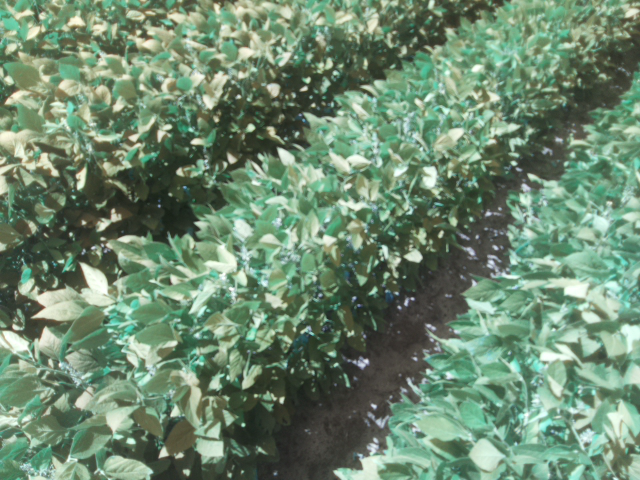

(200, 200, 3)
[{'name': 'conv2d_input', 'index': 0, 'shape': array([  1, 200, 200,   3], dtype=int32), 'shape_signature': array([  1, 200, 200,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
1


In [0]:
#This is the code that will need to be run on the R-Pi, it is easier to test it here

im_final = Xtest[7] #first image
cv2_imshow(test_Vectors[7])
print(testData[0].shape)

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite") 
interpreter.allocate_tensors()
print(interpreter.get_input_details()) #show details of input format

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
      

#test model
input_data = np.expand_dims(im_final, axis=0)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
        
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
results = np.squeeze(output_data)
print(int(np.argmax(results)))
        

In [0]:
print("Reference Water Stress Level")
cv2_imshow(test_Vectors[67+25]) # Show Image of water stress level 0 and 4 for reference 
print("Water Stress Level:0") 
cv2_imshow(test_Vectors[70+25])
print("Water Stress Level:2")
cv2_imshow(test_Vectors[9+25])
print("Water Stress Level:4")

In [0]:
from matplotlib import pyplot as plt
from vis.utils import utils
from keras import activations
import seaborn as sns
import cv2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

AttributeError: ignored